Estimating the value of a used car is one of the main everyday challenges in the automotive business. We believe that the sales price of a car is not only based on the value of the product itself, but is also heavily influenced by things like market trends, current availability, and politics.
With this challenge, we hope to raise some interest in this exciting topic and also gain some insight into what the main factors are that drive the value of a used car.

The data provided consists of almost 5000 real BMW cars that were sold via a b2b auction in 2018. The price shown in the table is the highest bid that was reached during the auction.

We have already done some data cleanup and filtered out cars with engine damage etc. However there may still be minor damages like scratches, but we do not have more information about that.

We have also extracted 8 criteria based on the equipment of cars that we think might have a good impact on the value of a used car. These criteria have been labeled feature1 to feature8 and are shown in the data below.

## 0. Importing Libraries

In [435]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import bisect

import warnings
warnings.filterwarnings('ignore')

##  1. Reading data

In [436]:
df = pd.read_csv("bmw_pricing_challenge.csv")

In [437]:
df.head()

,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,BMW,118,140411,100,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,2018-01-01
1,BMW,M4,13929,317,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,2018-02-01
2,BMW,320,183297,120,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,2018-02-01
3,BMW,420,128035,135,2014-07-01,diesel,red,convertible,True,True,False,False,True,True,True,True,25100,2018-02-01
4,BMW,425,97097,160,2014-12-01,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400,2018-04-01


In [438]:
df.shape

(4843, 18)

In [439]:
df.describe()

,mileage,engine_power,price
count,4.843000e+03,4843.00000,4843.000000
mean,1.409628e+05,128.98823,15828.081767
std,6.019674e+04,38.99336,9220.285684
min,-6.400000e+01,0.00000,100.000000
25%,1.029135e+05,100.00000,10800.000000
50%,1.410800e+05,120.00000,14200.000000
75%,1.751955e+05,135.00000,18600.000000
max,1.000376e+06,423.00000,178500.000000


In [440]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   maker_key          4843 non-null   object
 1   model_key          4843 non-null   object
 2   mileage            4843 non-null   int64 
 3   engine_power       4843 non-null   int64 
 4   registration_date  4843 non-null   object
 5   fuel               4843 non-null   object
 6   paint_color        4843 non-null   object
 7   car_type           4843 non-null   object
 8   feature_1          4843 non-null   bool  
 9   feature_2          4843 non-null   bool  
 10  feature_3          4843 non-null   bool  
 11  feature_4          4843 non-null   bool  
 12  feature_5          4843 non-null   bool  
 13  feature_6          4843 non-null   bool  
 14  feature_7          4843 non-null   bool  
 15  feature_8          4843 non-null   bool  
 16  price              4843 non-null   int64 


## 2. Exploratory Data Analysis

### 2.1. Missing Values

Check if the dataset contains any missing values.

In [441]:
print(df.isna().sum())

maker_key            0
model_key            0
mileage              0
engine_power         0
registration_date    0
fuel                 0
paint_color          0
car_type             0
feature_1            0
feature_2            0
feature_3            0
feature_4            0
feature_5            0
feature_6            0
feature_7            0
feature_8            0
price                0
sold_at              0
dtype: int64


### 2.2. Distribution of the target variable

Plot the probabilistic distribution of the target variable.

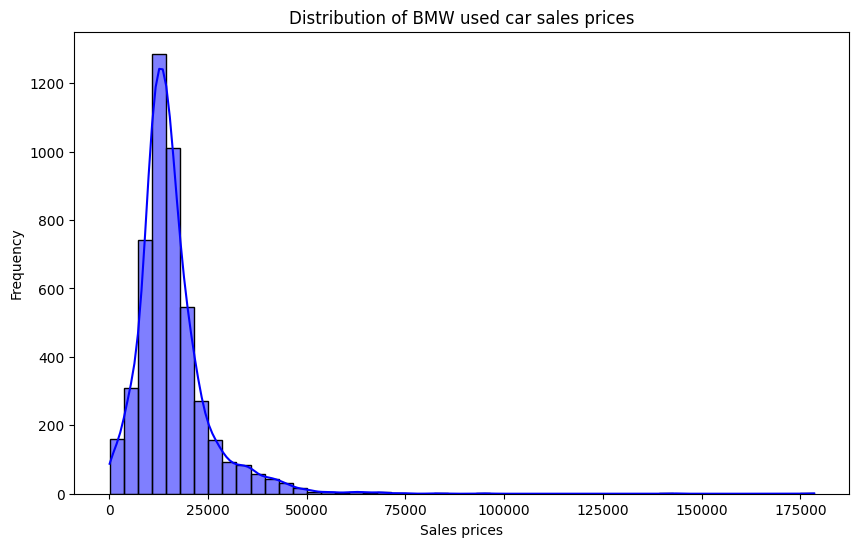

In [442]:
# The target variable is the estimation of BMW cars value, in while the price of the BMW cars.
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True, color='blue', bins=50)
plt.title('Distribution of BMW used car sales prices')
plt.xlabel('Sales prices')
plt.ylabel('Frequency')
plt.show()

### 2.3. Distribution of numerical variables

Plot the probabilistic distribution of the numerical features.

<Figure size 1800x1200 with 0 Axes>

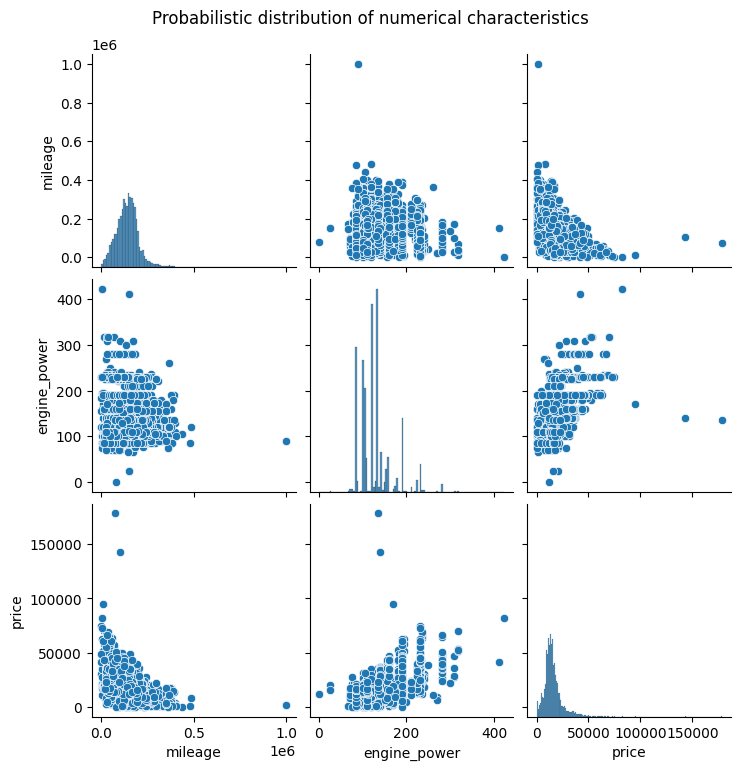

In [443]:
# Select numeric columns
numerical_features = ['mileage', 'engine_power', 'price']

# Set chart size
plt.figure(figsize=(18, 12))

# Use Seaborn's pairplot to create a matrix of density graphs
sns.pairplot(df[numerical_features], kind="scatter", diag_kind="hist", palette="Blues")

# Add a title
plt.suptitle('Probabilistic distribution of numerical characteristics', y=1.02)

# Display graph
plt.show()

### 2.4. Histogram of categorical variables

Plot the histogram of the categorical features.

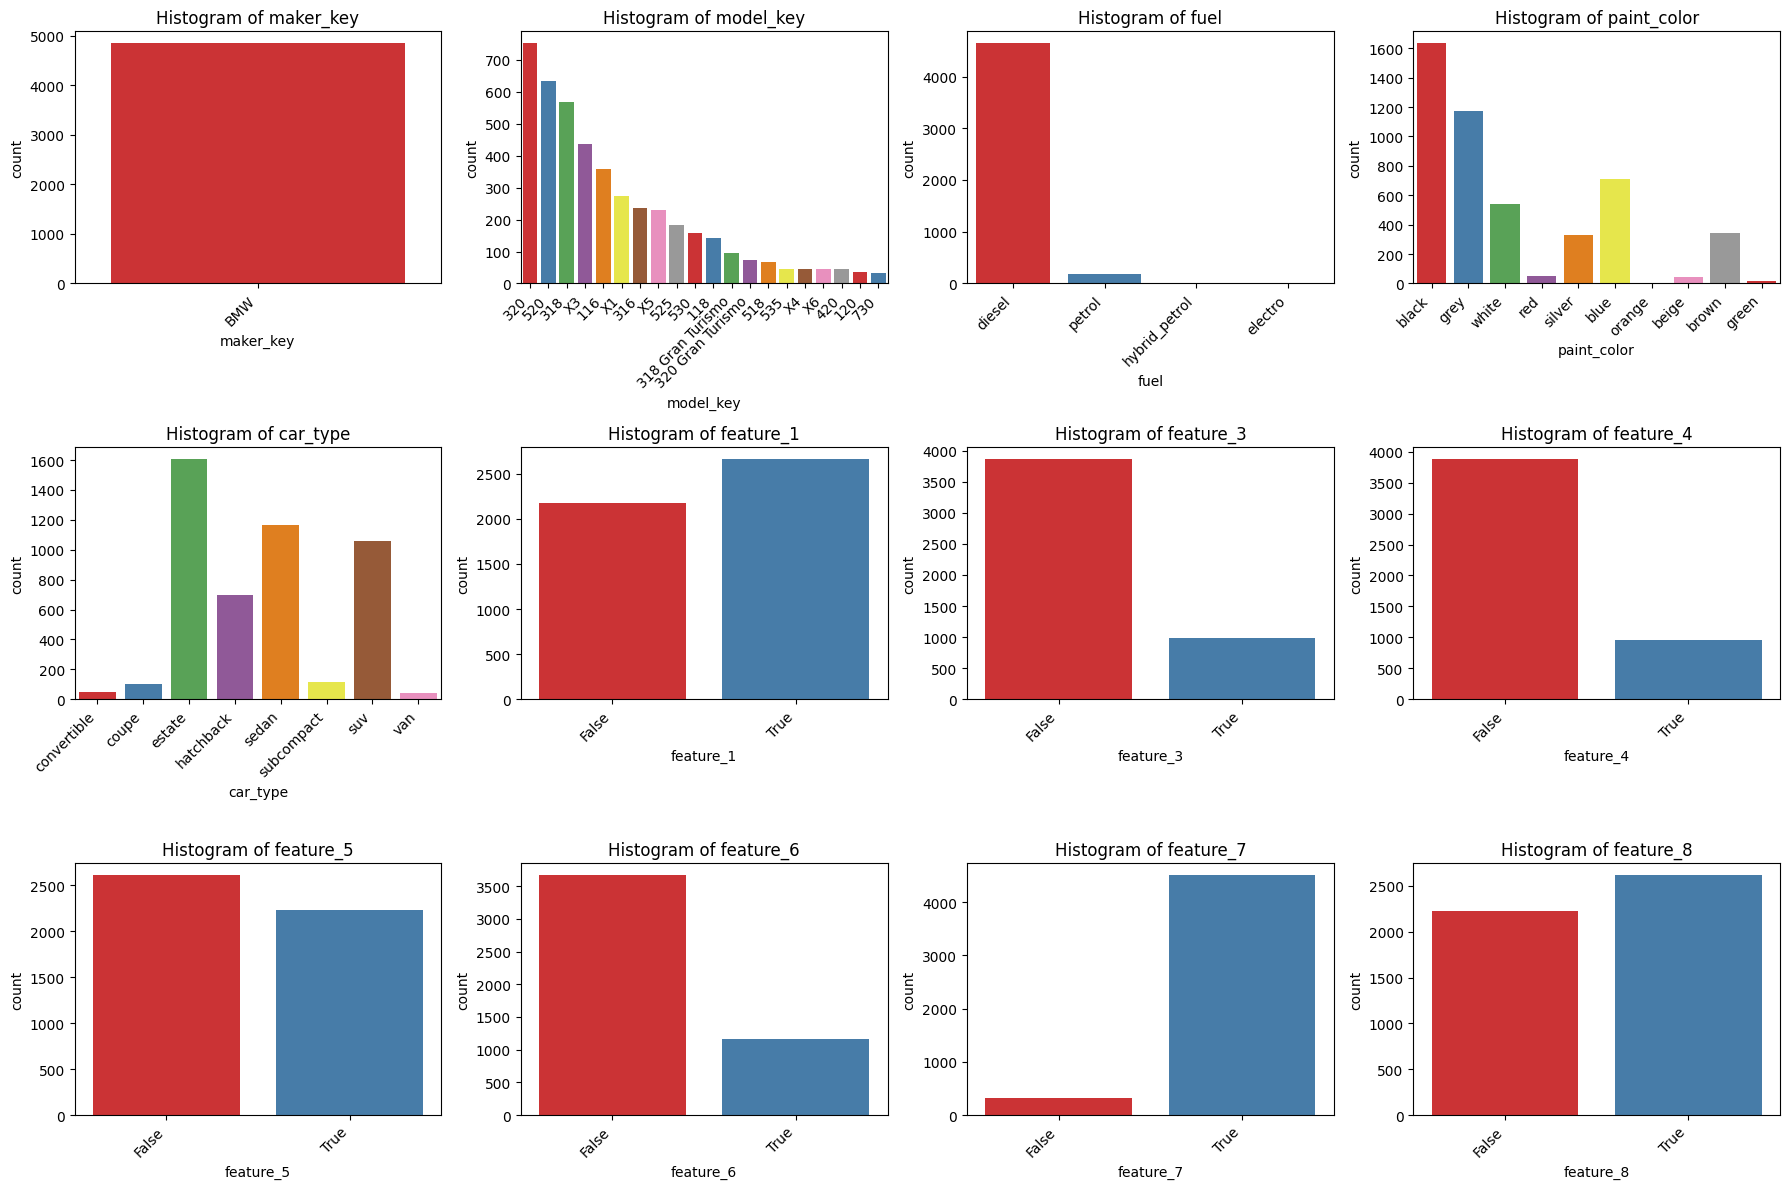

In [444]:
# Select category features columns
categorical_features = ['maker_key', 'model_key', 'fuel', 'paint_color', 'car_type','feature_1', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8']

# Set chart size
plt.figure(figsize=(18, 12))

# Use Seaborn's countplot to create the histogram of categorical features
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 4, i)
    
    # If the feature is 'model_key', limit the number of labels displayed or rotate them more.
    if feature == 'model_key':
        sns.countplot(x=feature, data=df, palette="Set1", order=df[feature].value_counts().index[:20])  # Example: display the first 20
    else:
        sns.countplot(x=feature, data=df, palette="Set1")
    
    plt.title(f'Histogram of {feature}')

    # Adjust label rotation in X
    plt.xticks(rotation=45, ha='right')  # We can adjust the rotation angle to suit your preferences
    
plt.tight_layout()
plt.show()

## 3. Data Splitting

Split the dataset into 2 training and test datasets.

In [445]:
# Define characteristics (X) and target variable (y)
#X = df.drop('price', axis=1)
X = df
y = df['price']

# Divide data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now, X_train and y_train are your training sets, and X_test and y_test are your test sets.

## 4. Feature Engineering

### 4.1. Removing non-predictive features

Remove any unnecessary feature.

In [446]:

# unnecessary_features = ['maker_key', 'model_key','registration_date','fuel','paint_color','car_type','sold_at']

# X_train = X_train.drop(columns=unnecessary_features)
# X_test = X_test.drop(columns=unnecessary_features)

# # Now, X_train and X_test contain only the necessary features

# X_train.tail(5)

Index(['feature_1', 'feature_5', 'feature_3', 'feature_2', 'feature_6',
       'feature_7'],
      dtype='object')


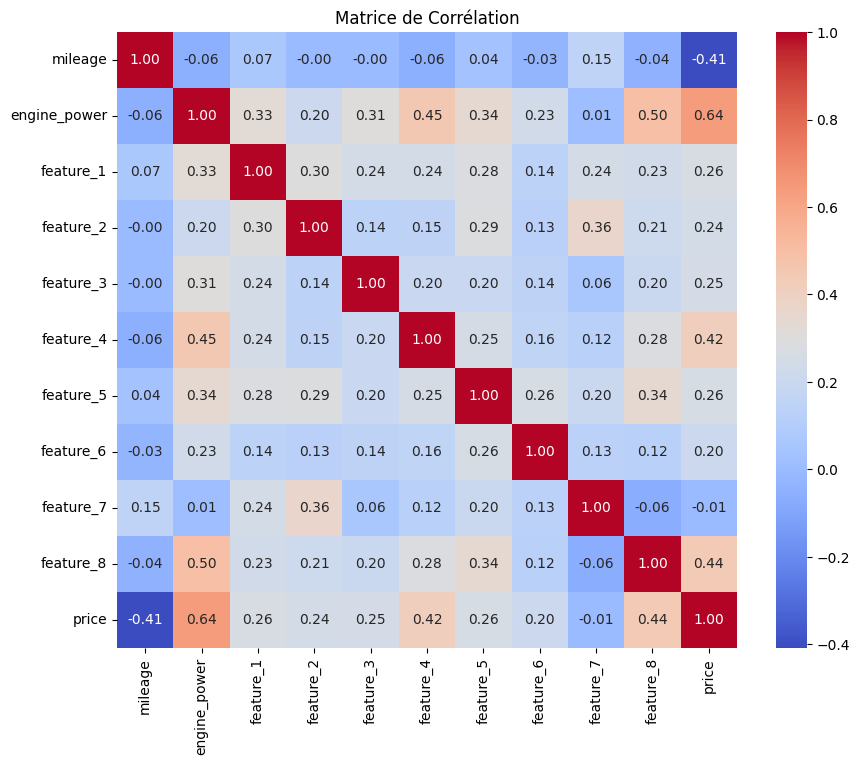

,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_4,feature_8,sold_at
4141,BMW,X1,149348,105,2013-04-01,diesel,blue,suv,True,True,2018-04-01
1983,BMW,114,57344,70,2013-10-01,diesel,grey,hatchback,False,False,2018-03-01
1507,BMW,318,99605,105,2014-09-01,diesel,black,estate,False,True,2018-07-01
1126,BMW,320,165561,120,2014-03-01,diesel,blue,estate,False,True,2018-05-01
180,BMW,320,181052,120,2014-10-01,diesel,black,estate,False,True,2018-04-01


In [447]:
correlation_matrix = X_train.corr()
correlation_with_target = correlation_matrix['price'].abs().sort_values(ascending=False)

# Set a threshold (e.g., 0.4) for non correlation
threshold = 0.4
unnecessary_features = correlation_with_target[correlation_with_target < threshold].index
print(unnecessary_features)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de Corrélation")
plt.show()

X_train = X_train.drop(columns=unnecessary_features)
X_test = X_test.drop(columns=unnecessary_features)

X_train = X_train.drop('price', axis=1)
X_test = X_test.drop('price', axis=1)


X_test.tail(5)

According to observation, features like engine_power, feature_4, feature_8 are more correlated with the price. 
And others are less correlated but not insignificant.

### 4.2. Creating new features

Creating polynomial features for numerical columns

In [448]:
degree = 2
numerical_columns = ['mileage', 'engine_power']

polynomial_features= PolynomialFeatures(degree=degree, include_bias=True)
X_train_poly = polynomial_features.fit_transform(X_train[numerical_columns])
X_test_poly = polynomial_features.fit_transform(X_test[numerical_columns])


### 4.3. Scaling numerical variables

In [449]:
scaler = StandardScaler()

# Scale the polynomial features for the training set
X_train_poly_scaled = scaler.fit_transform(X_train_poly)

# Scale the polynomial features for the test set
X_test_poly_scaled = scaler.transform(X_test_poly)


### 4.4. Categorical variables encoding

Convert categorical columns into numerical columns using label encoding or one-hot encoding.

In [450]:
#categorical_columns = ['maker_key', 'model_key','fuel','paint_color','car_type']
categorical_columns = ['fuel','paint_color','car_type']
# For One-Hot Encoding
X_train = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)

X_train.columns

Index(['maker_key', 'model_key', 'mileage', 'engine_power',
       'registration_date', 'feature_4', 'feature_8', 'sold_at',
       'fuel_electro', 'fuel_hybrid_petrol', 'fuel_petrol',
       'paint_color_black', 'paint_color_blue', 'paint_color_brown',
       'paint_color_green', 'paint_color_grey', 'paint_color_orange',
       'paint_color_red', 'paint_color_silver', 'paint_color_white',
       'car_type_coupe', 'car_type_estate', 'car_type_hatchback',
       'car_type_sedan', 'car_type_subcompact', 'car_type_suv',
       'car_type_van'],
      dtype='object')

In [451]:
print(X_train.shape)
print(X_test.shape)

(3874, 27)
(969, 26)


### 4.5. Converting boolean columns

In [452]:
# Assume boolean_columns contains the names of your boolean columns
boolean_columns = ['feature_4', 'feature_8']

# Convert boolean columns to numerical in the training set
for col in boolean_columns:
    X_train[col] = X_train[col].astype(int)

# Convert boolean columns to numerical in the test set
for col in boolean_columns:
    X_test[col] = X_test[col].astype(int)


In [453]:
X_train.tail(5)

,maker_key,model_key,mileage,engine_power,registration_date,feature_4,feature_8,sold_at,fuel_electro,fuel_hybrid_petrol,...,paint_color_red,paint_color_silver,paint_color_white,car_type_coupe,car_type_estate,car_type_hatchback,car_type_sedan,car_type_subcompact,car_type_suv,car_type_van
4426,BMW,X1,58189,100,2012-04-01,0,0,2018-06-01,0,0,...,0,0,0,0,0,0,0,0,1,0
466,BMW,530,178174,190,2012-05-01,0,1,2018-02-01,0,0,...,0,0,0,0,1,0,0,0,0,0
3092,BMW,M3,39250,317,2015-11-01,0,1,2018-05-01,0,0,...,0,0,0,0,0,0,1,0,0,0
3772,BMW,X3,75065,140,2014-10-01,0,1,2018-08-01,0,0,...,0,0,1,0,0,0,0,0,1,0
860,BMW,525,137237,160,2013-12-01,0,1,2018-04-01,0,0,...,0,0,0,0,1,0,0,0,0,0


## 5. Linear Regression

Fit a linear regression model on the training set. Evaluate the model on the testing set. Use the $R^2$ as an evaluation metric.

In [454]:
model_poly = LinearRegression()
model_poly.fit(X_train_poly_scaled, y_train)

# predicting over training & testing datasets
y_train_pred = model_poly.predict(X_train_poly_scaled)
y_test_pred = model_poly.predict(X_test_poly_scaled)

# model evaluation for testing set
rmse = (np.sqrt(mean_squared_error(y_test, y_test_pred)))
r2 = r2_score(y_test, y_test_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for testing set
--------------------------------------
RMSE is 5362.03478820771
R2 score is 0.595453037912709


In [455]:
# #Initialize the Linear Regression model
# model = LinearRegression()
# # Ensure columns are aligned between training and testing sets
# X_train, X_test = X_train.align(X_test, axis=1, fill_value=0)
# # Fit the model on the training set
# model.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = model.predict(X_test)

# # model evaluation for testing set
# rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
# r2 = r2_score(y_test, y_pred)

# print("The model performance for testing set")
# print("--------------------------------------")
# print('RMSE is {}'.format(rmse))
# print('R2 score is {}'.format(r2))

Plot feature importance/weight.

In [456]:
feature_cols = X_train.columns

# coef = pd.Series(model_poly.coef_, feature_cols)

# plt.figure(figsize=(8, 6))
# coef.plot(kind='bar', title='Model Coefficients')

## 6. Ridge

Fit a ridge regression model on the training set. Use cross-validation in order to tune the regularization parameter of the ridge model. Evaluate the model on the testing set. Use the $R^2$ as an evaluation metric.

In [457]:
## training the model
param_grid = {'alpha': [0.001, 0.005, 0.008, 0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.2, 0.5, 1, 10]}

model_ridge = Ridge()
search = GridSearchCV(model_ridge, param_grid, scoring='r2', cv=5)
search.fit(X_train_poly_scaled, y_train)

# predicting over training & testing datasets
y_train_pred = search.predict(X_train_poly_scaled)
y_test_pred = search.predict(X_test_poly_scaled)

print("Best estimator: ", search.best_estimator_)
print("Best CV R2 score: ", search.best_score_)

# model evaluation for testing set
rmse = (np.sqrt(mean_squared_error(y_test, y_test_pred)))
r2 = r2_score(y_test, y_test_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

Best estimator:  Ridge(alpha=10)
Best CV R2 score:  0.5959468691434451
The model performance for testing set
--------------------------------------
RMSE is 5370.723552858387
R2 score is 0.594140901238123


Plot feature importance/weight.

In [458]:
coef = pd.Series(model_ridge.coef_, feature_cols)

plt.figure(figsize=(8, 6))
coef.plot(kind='bar', title='Model Coefficients')

AttributeError: 'Ridge' object has no attribute 'coef_'

## 7. Lasso

Fit a lasso regression model on the training set. Use cross-validation in order to tune the regularization parameter of the ridge model. Evaluate the model on the testing set. Use the $R^2$ as an evaluation metric.

In [459]:
## training the model
param_grid = {'alpha': [10**(-5), 10**(-4), 10**(-3), 0.005, 0.008, 0.01, 0.05, 0.1, 0.5, 1, 10]}

model_lasso = Lasso()
search = GridSearchCV(model_lasso, param_grid, scoring='r2', cv=5)
search.fit(X_train_poly_scaled, y_train)

# predicting over training & testing datasets
y_train_pred = search.predict(X_train_poly_scaled)
y_test_pred = search.predict(X_test_poly_scaled)

print("Best estimator: ", search.best_estimator_)
print("Best CV R2 score: ", search.best_score_)

# model evaluation for testing set
rmse = (np.sqrt(mean_squared_error(y_test, y_test_pred)))
r2 = r2_score(y_test, y_test_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

Best estimator:  Lasso(alpha=10)
Best CV R2 score:  0.5964659415911203
The model performance for testing set
--------------------------------------
RMSE is 5367.961162646998
R2 score is 0.594558294859459


Plot feature importance/weight.

In [460]:
coef = pd.Series(search.best_estimator_.coef_, feature_cols)
coef.plot(kind='bar', title='Model Coefficients')

ValueError: Length of values (6) does not match length of index (27)